# Operator Learning - Time-Dependent Convolutional Neural Operator

In **operator learning**, models are tasked with handling functions as inputs and outputs, which are stored on a computer in their **discrete representations** (e.g. images). They should have ability to process and generalize across various representations of the inputs, such as different mesh refinements.

Data-driven models that exhibit the mentioned properties are commonly known as ***Neural Operators***.

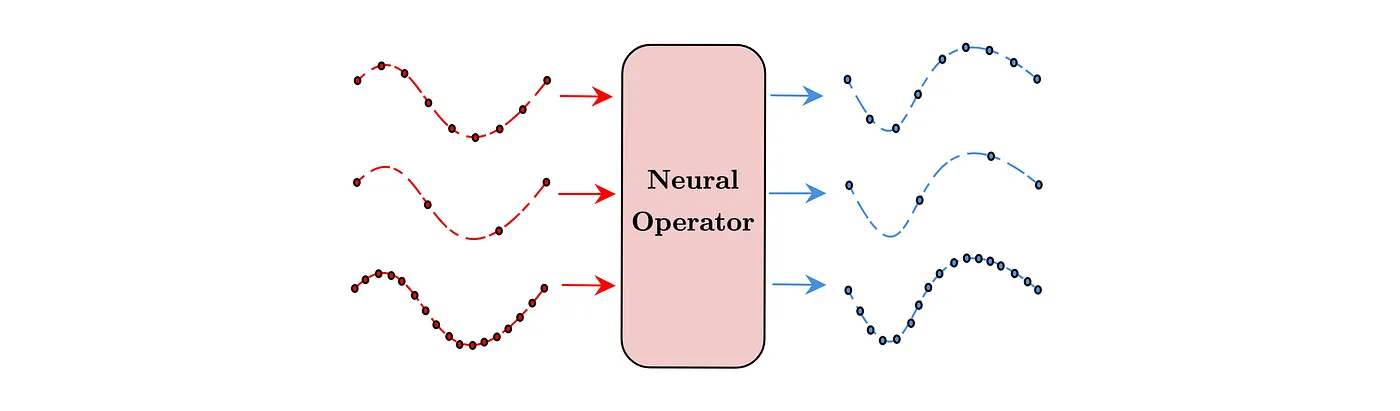



## Convolutional Neural Operator (CNO)

- Introduced in the paper [Convolutional Neural Operators for robust and accurate learning of PDEs
](https://arxiv.org/abs/2302.01178).
- CNO is formulated as an **iterative architecture**
- CNO uses **convolutions** parametrized in the **physical domain** (**local** operations)
- CNO uses U-Net like architecture for multi-scale learning
- CNO uses **skip connections** to enchance the training

### You can read the CNO blog on [this link](https://medium.com/@bogdan.raonke/operator-learning-convolutional-neural-operators-for-robust-and-accurate-learning-of-pdes-ebbc43b57434).


## Time-Dependent Neural Operators

Observe a time-dependent solution of a PDE.


*   How can we incorporate temporal information into our models?
*   Can we generate the entire time evolution given **only initial datum**?
*   Can we evaluate the approximate solution **at any point in time**?


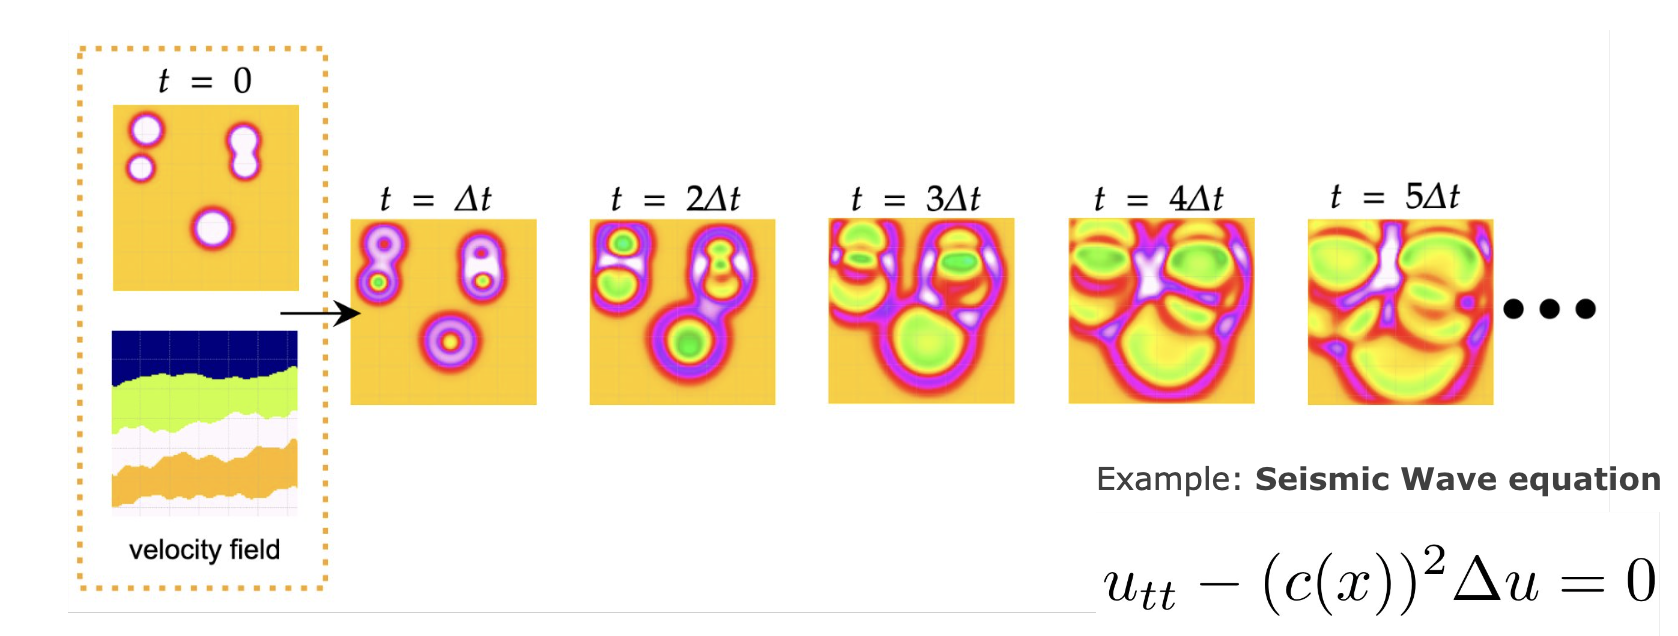


*  Use conditional normalization layers.
*  Make all the layers time-dependent!
*  CNO becomes continuous in time

  

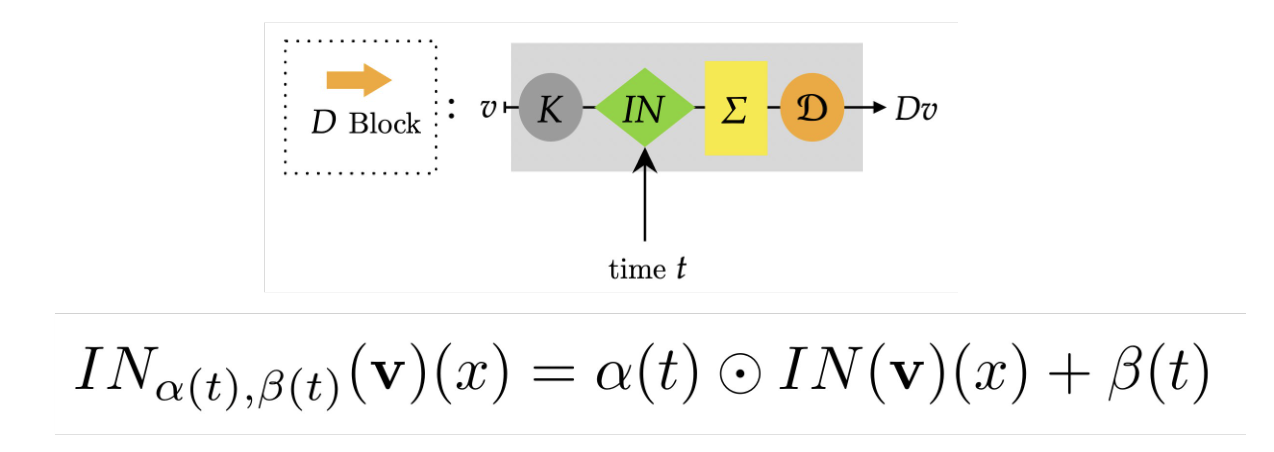



*   All2All training - One model can be evaluated at any point in time
*   All2All training serves as data augmentation stratery
*   Given one trajectory (or a solution) of length $T$, there is $O(T^2)$ training samples.

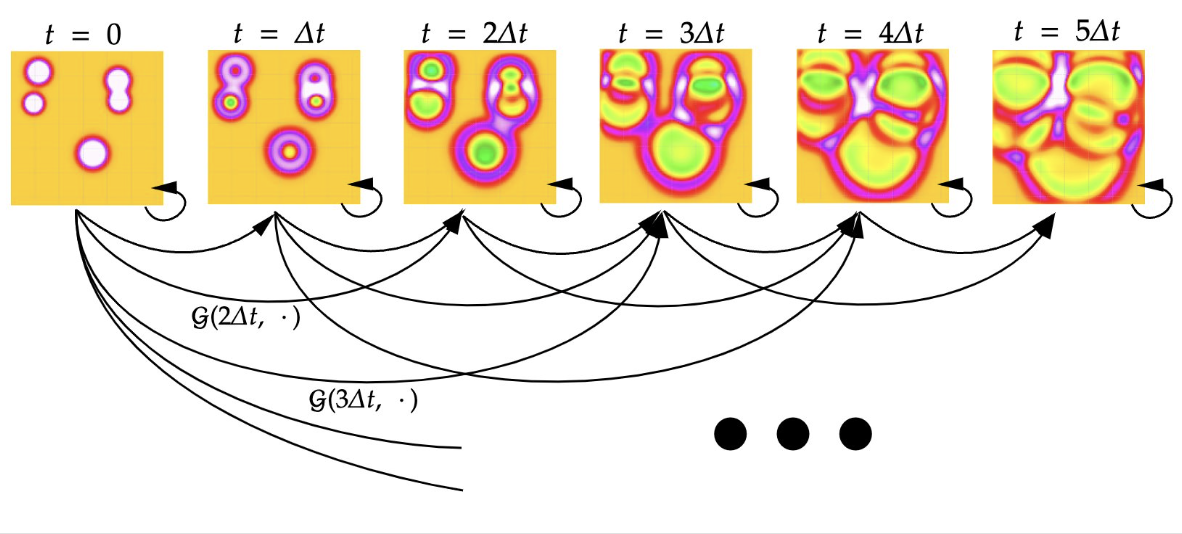

\\


## Implementation of time-dependent CNO

- **In this notebook, we will implement 1d, time-dependent pytorch version of the CNO model**.
- We will use **antialias interpoaltion** from the torch library.

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim import AdamW
import matplotlib.pyplot as plt

In the following code, we will define
* **FILM** layer - time-conditional normalization layer
* **CNO LReLu** activation fucntion
* **CNO building block** (CNOBlock) → Conv1d - BatchNorm - Activation
* **Lift/Project Block** (Important for embeddings)
* **Residual Block** → Conv1d - BatchNorm - Activation - Conv1d - BatchNorm - *Skip Connection*
* **ResNet** → Stacked ResidualBlocks (several blocks applied iteratively)

In [ ]:
#---------------------
# Time-conditional BN:
#---------------------

class FILM(torch.nn.Module):
    def __init__(self,
                channels,
                use_bn = True):
        super(FILM, self).__init__()
        self.channels = channels

        self.inp2scale = nn.Linear(in_features=1, out_features=channels, bias=True)
        self.inp2bias = nn.Linear(in_features=1, out_features=channels, bias=True)

        self.inp2scale.weight.data.fill_(0)
        self.inp2scale.bias.data.fill_(1)
        self.inp2bias.weight.data.fill_(0)
        self.inp2bias.bias.data.fill_(0)

        if use_bn:
          self.norm = nn.BatchNorm1d(channels)
        else:
          self.norm = nn.Identity()

    def forward(self, x, time):

        x = self.norm(x)
        time = time.reshape(-1,1).type_as(x)
        scale     = self.inp2scale(time)
        bias      = self.inp2bias(time)
        scale = scale.unsqueeze(2).expand_as(x)
        bias  = bias.unsqueeze(2).expand_as(x)

        return x * scale + bias


In [ ]:
#---------------------
# Activation Function:
#---------------------

class CNO_LReLu(nn.Module):
    def __init__(self,
                 in_size,
                 out_size
                 ):
        super(CNO_LReLu, self).__init__()

        self.in_size = in_size
        self.out_size = out_size
        self.act = nn.LeakyReLU()

    def forward(self, x):

      x = F.interpolate(x.unsqueeze(2), size = (1,2 * self.in_size), mode = "bicubic", antialias = True)
      x = self.act(x)
      x = F.interpolate(x, size = (1,self.out_size), mode = "bicubic", antialias = True)

      return x[:,:,0]

#--------------------
# CNO Block:
#--------------------

class CNOBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 in_size,
                 out_size,
                 use_bn = True
                 ):
        super(CNOBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.in_size  = in_size
        self.out_size = out_size

        #-----------------------------------------

        # We apply Conv -> BN (optional) -> Activation
        # Up/Downsampling happens inside Activation

        self.convolution = torch.nn.Conv1d(in_channels = self.in_channels,
                                           out_channels= self.out_channels,
                                           kernel_size = 3,
                                           padding     = 1)

        self.batch_norm  = FILM(self.out_channels, use_bn)

        self.act           = CNO_LReLu(in_size  = self.in_size,
                                       out_size = self.out_size)


    def forward(self, x, time):
        x = self.convolution(x)
        x = self.batch_norm(x, time)
        return self.act(x)

#--------------------
# Lift/Project Block:
#--------------------

class LiftProjectBlock(nn.Module):
    def __init__(self,
                in_channels,
                out_channels,
                size,
                latent_dim = 64
                ):
        super(LiftProjectBlock, self).__init__()

        self.inter_CNOBlock = CNOBlock(in_channels       = in_channels,
                                        out_channels     = latent_dim,
                                        in_size          = size,
                                        out_size         = size,
                                        use_bn           = False)

        self.convolution = torch.nn.Conv1d(in_channels  = latent_dim,
                                           out_channels = out_channels,
                                           kernel_size  = 3,
                                           padding      = 1)


    def forward(self, x, time):
        x = self.inter_CNOBlock(x, time)
        x = self.convolution(x)
        return x

#--------------------
# Residual Block:
#--------------------

class ResidualBlock(nn.Module):
    def __init__(self,
                 channels,
                 size,
                 use_bn = True
                 ):
        super(ResidualBlock, self).__init__()

        self.channels = channels
        self.size     = size

        #-----------------------------------------

        # We apply Conv -> BN (optional) -> Activation -> Conv -> BN (optional) -> Skip Connection
        # Up/Downsampling happens inside Activation

        self.convolution1 = torch.nn.Conv1d(in_channels = self.channels,
                                            out_channels= self.channels,
                                            kernel_size = 3,
                                            padding     = 1)
        self.convolution2 = torch.nn.Conv1d(in_channels = self.channels,
                                            out_channels= self.channels,
                                            kernel_size = 3,
                                            padding     = 1)

        self.batch_norm1  = FILM(self.channels, use_bn)
        self.batch_norm2  = FILM(self.channels, use_bn)

        self.act           = CNO_LReLu(in_size  = self.size,
                                       out_size = self.size)


    def forward(self, x, time):
        out = self.convolution1(x)
        out = self.batch_norm1(out, time)
        out = self.act(out)
        out = self.convolution2(out)
        out = self.batch_norm2(out, time)
        return x + out

#--------------------
# ResNet:
#--------------------

class ResNet(nn.Module):
    def __init__(self,
                 channels,
                 size,
                 num_blocks,
                 use_bn = True
                 ):
        super(ResNet, self).__init__()

        self.channels = channels
        self.size = size
        self.num_blocks = num_blocks

        self.res_nets = []
        for _ in range(self.num_blocks):
            self.res_nets.append(ResidualBlock(channels = channels,
                                              size = size,
                                              use_bn = use_bn))

        self.res_nets = torch.nn.Sequential(*self.res_nets)

    def forward(self, x, time):
        for i in range(self.num_blocks):
            x = self.res_nets[i](x, time)
        return x


In [ ]:
X = torch.rand((1,2,128))
T = torch.zeros((1,1))

#-------------
# Check your normalization layer
#-------------
film = FILM(channels=2)
Y = film(X,T)
assert tuple(Y.shape) == (1,2,128)

#-------------
# Check your activation
#-------------
cno_lrelu = CNO_LReLu(in_size  = 128,
                      out_size = 128)
Y = cno_lrelu(X)
assert tuple(Y.shape) == (1,2,128)

#-------------
# Check your CNOBlock
#-------------
cno_block = CNOBlock(in_channels = 2,
                    out_channels = 4,
                    in_size = 128,
                    out_size = 64,
                    use_bn = True)
Y = cno_block(X, T)
assert tuple(Y.shape) == (1,4,64)

#-------------
# Check your LiftProjectBlock
#-------------
lift_project = LiftProjectBlock(in_channels = 2,
                                out_channels = 4,
                                size = 128)
Y = lift_project(X, T)
assert tuple(Y.shape) == (1,4,128)

#-------------
# Check your ResidualBlock
#-------------
residual_bl = ResidualBlock(channels = 2,
                            size = 128,
                            use_bn = True)
Y = residual_bl(X, T)
assert tuple(Y.shape) == (1,2,128)

#-------------
# Check your ResNet
#-------------
res_net = ResNet(channels = 2,
                 size = 128,
                 num_blocks = 3,
                 use_bn = True)
Y = res_net(X, T)
assert tuple(Y.shape) == (1,2,128)


####Once that all the CNO ingredients are implemented, we can code the **CNO model**
- CNO model has a UNet like architecture with additional ResNets that connect corresponding levels of the **encoder** and the **decoder**
- As in the case of FNO, there are **lifting** and **projection** layers.
- We assume that the input and the output sizes are equal, although, one can easily generalize to different sizes.

In [ ]:
#--------------------
# CNO:
#--------------------

class CNO1d(nn.Module):
    def __init__(self,
                 in_dim,                    # Number of input channels.
                 out_dim,                   # Number of input channels.
                 size,                      # Input and Output spatial size (required )
                 N_layers,                  # Number of (D) or (U) blocks in the network
                 N_res = 4,                 # Number of (R) blocks per level (except the neck)
                 N_res_neck = 4,            # Number of (R) blocks in the neck
                 channel_multiplier = 16,   # How the number of channels evolve?
                 use_bn = True,             # Add BN? We do not add BN in lifting/projection layer
                ):

        super(CNO1d, self).__init__()

        self.N_layers = int(N_layers)         # Number od (D) & (U) Blocks
        self.lift_dim = channel_multiplier//2 # Input is lifted to the half of channel_multiplier dimension
        self.in_dim   = in_dim
        self.out_dim  = out_dim
        self.channel_multiplier = channel_multiplier  # The growth of the channels

        ######## Num of channels/features - evolution ########

        self.encoder_features = [self.lift_dim] # How the features in Encoder evolve (number of features)
        for i in range(self.N_layers):
            self.encoder_features.append(2 ** i *   self.channel_multiplier)

        self.decoder_features_in = self.encoder_features[1:] # How the features in Decoder evolve (number of features)
        self.decoder_features_in.reverse()
        self.decoder_features_out = self.encoder_features[:-1]
        self.decoder_features_out.reverse()

        for i in range(1, self.N_layers):
            self.decoder_features_in[i] = 2*self.decoder_features_in[i] #Pad the outputs of the resnets (we must multiply by 2 then)

        ######## Spatial sizes of channels - evolution ########

        self.encoder_sizes = []
        self.decoder_sizes = []
        for i in range(self.N_layers + 1):
            self.encoder_sizes.append(size // 2 ** i)
            self.decoder_sizes.append(size // 2 ** (self.N_layers - i))


        ######## Define Lift and Project blocks ########

        self.lift   = LiftProjectBlock(in_channels = in_dim,
                                      out_channels = self.encoder_features[0],
                                      size = size)

        self.project   = LiftProjectBlock(in_channels = self.encoder_features[0] + self.decoder_features_out[-1],
                                          out_channels = out_dim,
                                          size = size)

        ######## Define Encoder, ED Linker and Decoder networks ########

        self.encoder         = nn.ModuleList([(CNOBlock(in_channels  = self.encoder_features[i],
                                                        out_channels = self.encoder_features[i+1],
                                                        in_size      = self.encoder_sizes[i],
                                                        out_size     = self.encoder_sizes[i+1],
                                                        use_bn       = use_bn))
                                               for i in range(self.N_layers)])

        # After the ResNets are executed, the sizes of encoder and decoder might not match (if out_size>1)
        # We must ensure that the sizes are the same, by aplying CNO Blocks
        self.ED_expansion     = nn.ModuleList([(CNOBlock(in_channels = self.encoder_features[i],
                                                        out_channels = self.encoder_features[i],
                                                        in_size      = self.encoder_sizes[i],
                                                        out_size     = self.decoder_sizes[self.N_layers - i],
                                                        use_bn       = use_bn))
                                               for i in range(self.N_layers + 1)])

        self.decoder         = nn.ModuleList([(CNOBlock(in_channels  = self.decoder_features_in[i],
                                                        out_channels = self.decoder_features_out[i],
                                                        in_size      = self.decoder_sizes[i],
                                                        out_size     = self.decoder_sizes[i+1],
                                                        use_bn       = use_bn))
                                               for i in range(self.N_layers)])

        ####################### Define ResNets Blocks ################################################################

        # Here, we define ResNet Blocks.

        # Operator UNet:
        # Outputs of the middle networks are patched (or padded) to corresponding sets of feature maps in the decoder

        self.res_nets = []
        self.N_res = int(N_res)
        self.N_res_neck = int(N_res_neck)

        # Define the ResNet networks (before the neck)
        for l in range(self.N_layers):
              self.res_nets.append(ResNet(channels = self.encoder_features[l],
                                          size = self.encoder_sizes[l],
                                          num_blocks = self.N_res,
                                          use_bn = use_bn))

        self.res_net_neck = ResNet(channels = self.encoder_features[self.N_layers],
                                  size = self.encoder_sizes[self.N_layers],
                                  num_blocks = self.N_res_neck,
                                  use_bn = use_bn)

        self.res_nets = torch.nn.Sequential(*self.res_nets)

    def forward(self, x, time):

      x = self.lift(x, time) #Execute Lift
      skip = []

      # Execute Encoder
      for i in range(self.N_layers):

          #Apply ResNet & save the result
          y = self.res_nets[i](x, time)
          skip.append(y)

          # Apply (D) block
          x = self.encoder[i](x, time)


      # Apply the deepest ResNet (bottle neck)
      x = self.res_net_neck(x, time)

      # Execute Decode
      for i in range(self.N_layers):

          # Apply (I) block (ED_expansion) & cat if needed
          if i == 0:
              x = self.ED_expansion[self.N_layers - i](x, time) #BottleNeck : no cat
          else:
              x = torch.cat((x, self.ED_expansion[self.N_layers - i](skip[-i], time)),1)

          # Apply (U) block
          x = self.decoder[i](x, time)

      # Cat & Execute Projetion
      x = torch.cat((x, self.ED_expansion[0](skip[0], time)),1)
      x = self.project(x, time)

      return x


## Example

We will solve an **unknown, time-dependent PDE** from the data. The data has one spatial and one time dimension.

The data is given in terms of solution **trajectories**. Each trajectory has the shape $(T, X)$, where $T$ is the te,mporal resolution, while $X$ is the spatial resolution.

We wish to learn time-dependent operator $G$

$$
G : \left( u(\cdot, t), \tau \right) \mapsto  u(\cdot, t + \tau)
$$

Note that the data is generated for you (see the file *pde_data.npy*)

In [ ]:
class PDEDataset(Dataset):
    def __init__(self,
                 which="training",
                 training_samples = 256):

        self.data = np.load("pde_data.npy")

        self.T = 6
        # Precompute all possible (t_initial, t_final) pairs within the specified range.
        self.time_pairs = [(i, j) for i in range(0, self.T) for j in range(i + 1, self.T)]
        self.len_times  = len(self.time_pairs)

        self.N_max = 512 * self.len_times
        self.n_val  = 32 * self.len_times
        self.n_test = 128 * self.len_times

        if which == "training":
            self.length = training_samples * self.len_times
            self.start = 0
        elif which == "validation":
            self.length = self.n_val * self.len_times
            self.start = (self.N_max - self.n_val - self.n_test) * self.len_times
        elif which == "test":
            self.length = self.n_test * self.len_times
            self.start = (self.N_max  - self.n_test) * self.len_times

        self.mean = 0
        self.std  = 0.3835

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        sample_idx = index // self.len_times
        time_pair_idx = index % self.len_times
        t_inp, t_out = self.time_pairs[time_pair_idx]
        time = (t_out - t_inp) * 0.2 # We multiply by 0.2 so that the final time corresponds to 1.0

        inputs = torch.from_numpy(self.data[sample_idx, t_inp]).type(torch.float32).reshape(1, 128)
        inputs = (inputs - self.mean)/self.std #Normalize
        inputs_t = torch.ones(1, 128).type(torch.float32) * time
        inputs = torch.cat((inputs, inputs_t), 0) #Cat time to the input

        outputs = torch.from_numpy(self.data[sample_idx, t_out]).type(torch.float32).reshape(1, 128)
        outputs = (outputs - self.mean)/self.std #Normalize

        return float(time), inputs, outputs

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

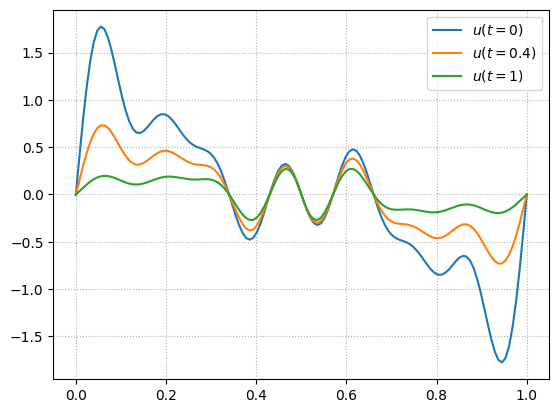

In [ ]:
id_sample = 32
pde_data = np.load("pde_data.npy")

plt.plot(np.linspace(0,1,128),pde_data[id_sample,0,:], label = "$u(t = 0)$")
plt.plot(np.linspace(0,1,128),pde_data[id_sample,2,:], label = "$u(t = 0.4)$")
plt.plot(np.linspace(0,1,128),pde_data[id_sample, 5,:], label = "$u(t = 1)$")
plt.grid(True, which="both", ls=":")
plt.legend()

In [ ]:
n_train = 100
batch_size = 10

training_set = DataLoader(PDEDataset("training", 256), batch_size=batch_size, shuffle=True)
testing_set = DataLoader(PDEDataset("validation"), batch_size=batch_size, shuffle=False)

learning_rate = 0.001
epochs = 10
step_size = 2
gamma = 0.5

In [ ]:
N_layers = 4
N_res    = 1
N_res_neck = 4
channel_multiplier = 16

cno = CNO1d(in_dim = 2,                                    # Number of input channels.
            out_dim = 1,                                   # Number of input channels.
            size = 128,                                    # Input and Output spatial size (required )
            N_layers = N_layers,                           # Number of (D) or (U) blocks in the network
            N_res = N_res,                                 # Number of (R) blocks per level (except the neck)
            N_res_neck = N_res_neck,                       # Number of (R) blocks in the neck
            channel_multiplier = channel_multiplier,       # How the number of channels evolve?
            use_bn = False)


## Training

Note that it takes a few minutes to train a model for 1 epoch on a CPU!

In [ ]:
optimizer = AdamW(cno.parameters(), lr=learning_rate, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = nn.L1Loss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (time_batch, input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        time_batch = time_batch.type(torch.float32)
        output_pred_batch = cno(input_batch, time_batch)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        cno.eval()
        test_relative_l2 = 0.0
        for step, (time_batch, input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = cno(input_batch, time_batch)
            loss_f = (torch.mean((abs(output_pred_batch - output_batch))) / torch.mean(abs(output_batch))) * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L1 Test Norm:", test_relative_l2)



######### Epoch: 1  ######### Train Loss: 0.016330278495540067  ######### Relative L1 Test Norm: 4.313088921043608
######### Epoch: 2  ######### Train Loss: 0.008296221009610841  ######### Relative L1 Test Norm: 1.2351970735523436
######### Epoch: 3  ######### Train Loss: 0.007390829732078903  ######### Relative L1 Test Norm: 1.4273871176772648
######### Epoch: 4  ######### Train Loss: 0.004713912559357898  ######### Relative L1 Test Norm: 0.9044106307129065
######### Epoch: 5  ######### Train Loss: 0.004898034433911865  ######### Relative L1 Test Norm: 0.9880760241713789
######### Epoch: 6  ######### Train Loss: 0.0036173846644184473  ######### Relative L1 Test Norm: 0.760829879095157
######### Epoch: 7  ######### Train Loss: 0.0035884488249090887  ######### Relative L1 Test Norm: 0.7508625459753805
######### Epoch: 8  ######### Train Loss: 0.00319245945380923  ######### Relative L1 Test Norm: 0.6668597621636259
######### Epoch: 9  ######### Train Loss: 0.0031568781875345544  ########

## Plot

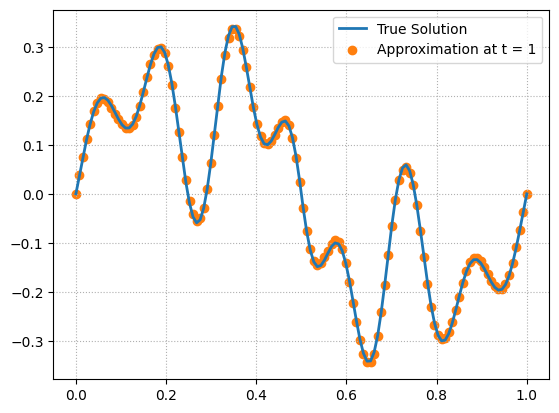

In [ ]:
mean = 0
std  = 0.3835

idx_test = 492
pde_data = np.load("pde_data.npy")

time = 1.0
inputs = torch.from_numpy(pde_data[idx_test, 0]).type(torch.float32).reshape(1, 128)
inputs = (inputs - mean)/std
inputs_t = torch.ones(1, 128).type(torch.float32) * 1.0
inputs = torch.cat((inputs, inputs_t), 0).reshape((1,2,128))
times = time * torch.ones((1))

outputs = torch.from_numpy(pde_data[idx_test, -1]).type(torch.float32).reshape(1, 128)
output_pred = cno(inputs, times) * std + mean


outputs = outputs.numpy()
output_pred = output_pred.detach().numpy()

plt.figure()
plt.grid(True, which="both", ls=":")
X = np.linspace(0,1, 128)
plt.plot(X,outputs[0], label="True Solution", c="C0", lw=2)
plt.scatter(X,output_pred[0], label="Approximation at t = 1", c="C1")
p = 1
plt.legend()

# TO DO at home:

*   Compute the testing errors at fixed times. For example, compute the testing errors at $t = 1.0$ i.e. the testing error of the operator
$$
G : u(\cdot, 0)\mapsto  u(\cdot, 1.0)
$$

* Plot the evolution of the testing error in time.




### Official CNO2d repo can be found [here](https://github.com/bogdanraonic3/ConvolutionalNeuralOperator/tree/main)
